<table style='border: none' align='left'>
   <tr style='border: none'>
      <th style='border: none'><font face='verdana' size='5' color='black'><b>Use XGBoost to classify tumors with IBM Watson Machine Learning</b></th>
      <th style='border: none'><img src='https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true' alt='Watson Machine Learning icon' height='40' width='40'></th>
   </tr>
   <tr style='border: none'>
       <th style='border: none'><img src='https://raw.githubusercontent.com/pmservice/wml-sample-notebooks/master/images/cancer_banner-06.png' alt='Icon' width='700'> </th>
   </tr>
</table>

This notebook demonstates how to obtain data from the IBM Watson Studio Gallery, create a predictive model, and score the model.

You will use a publicly available data set, the Breast Cancer Wisconsin (Diagnostic) Data Set, to train an XGBoost Model to classify breast cancer tumors (as benign or malign). There are 569 data points in the Breast Cancer Wisconsin (Diagnostic) Data Set, and each data point has a set of predictors such as radius, texture, perimeter, and area. XGBoost stands for “E<b>x</b>treme <b>G</b>radient <b>Boost</b>ing”.

The XGBoost classifier makes its predictions based on the majority vote from a collection of models which are a set of classification trees. It combines weak learners to create a single strong learner. It is a sequential training process where new learners focus on the misclassified examples of previous learners.


The notebook uses `scikit-learn 0.19`, `xgboost 0.80`, and `watson-machine-learning-client-V4`.


Some familiarity with Python is helpful. This notebook is compatible Watson Studio Local 2.0 and Python 3.5.


## Learning goals

You will learn how to:

-  Load a `csv` file into a Pandas DataFrame
-  Explore data
-  Prepare data for training and evaluation
-  Create an XGBoost machine learning model
-  Train and evaluate the model
-  Use cross-validation to optimize model's hyperparameters
-  Persist the model in the Watson Machine Learning repository
-  Deploy the model for online scoring
-  Score test data


## Table of Contents

This notebook contains the following parts:

1.	[Setting up](#setup)
2.	[Load and explore the data](#load)
3.	[Create an XGBoost model](#model)<br>
    3.1 [Split data](#prepare)<br>
    3.2 [Create an XGBoost model](#create)
4.	[Persist the model](#persistence)
5.	[Deploy and score the model in the WML repository](#scoring)
6.	[Summary and next steps](#summary)

<a id='setup'></a>
## 1. Setting up

To get started on Watson Studio Local, find documentation on installion and set up <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.0.0/wsj/getting-started/get-started-wdp.html" target="_blank" rel="noopener no referrer">here</a>.

-  Local Python environment configurations:
  + Python 3.5
  + XGBoost
  + watson-machine-learning-client-V4
  + PixieDust
  + matplotlib
  + Seaborn

- Download the **Breast Cancer Wisconsin (Diagnostic) Data Set** dataset from the <a href="https://dataplatform.ibm.com/community?context=analytics" target="_blank" rel="noopener no referrer">Watson Studio Gallery</a>. 
We provide the code to download the data set in [step 2](#load).

<a id='load'></a>
## 2. Load and explore the data

In this section, you will load the data into a Pandas DataFrame and perform an exploratory data analysis (EDA).

To load the data into a Pandas DataFrame, use `wget` to download the data first and `pandas` to read the data.

**Example**: First, you need to install the required packages. You can do this by running the following code. Run it only once.<BR><BR>

<div class="alert alert-block alert-warning">
1. To avoid re-installation when re-running the notebook, try running your notebooks in custom environments. To find out more about setting up custom environments, see <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.0.0/wsj/analyze-data/customize-envs.html">here</a>.<br>
2. To simply hide the output of pip install instead, use <tt>-q</tt> after <tt>!pip install</tt>.
</div>

In [ ]:
!pip install --upgrade wget --upgrade pip

In [2]:
# Get the data.
import wget
import os

wisconsin_data = 'BreastCancerwisconsin_data.csv' 

if not os.path.isfile(wisconsin_data):
    link_to_data = 'https://dataplatform.cloud.ibm.com/data/exchange-api/v1/entries/c173693bf48aeb22e41bbe2b41d79c1f/data?accessKey=5f41fd5a963ddd59ba6c746a21b85361'
    wisconsin_data = wget.download(link_to_data)

print(wisconsin_data)

BreastCancerWisconsinDataSet (4).csv


The csv file **BreastCancerWisconsinDataSet.csv** is downloaded. Run the code in the following cells to load the file as a pandas dataframe.

<div class="alert-block alert-info"><br>Update the packages to ensure that you have the latest version.<br><br>
</div>

PixieDust is an open-source Python helper library that works as an add-on to Jupyter notebooks to improve the user experience of working with data.  
PixieDust documentation/code can be found <a href="https://github.com/pixiedust/pixiedust" target="_blank" rel="noopener no referrer">here</a>.  

In [ ]:
!pip install --upgrade pixiedust

In [4]:
import pandas as pd

df = pd.read_csv(wisconsin_data).iloc[:, 1:]

Import ``pixiedust``.

In [ ]:
import pixiedust

You can run the following method if you don't want pixiedust collecting user statistics.

In [ ]:
pixiedust.optOut()

In this notebook, ``pixiedust`` will only be used as a dataframe viewer. However, ``pixiedust`` can also be used as a data visualization tool. You can find the details of the visualization functionality of ``pixiedust`` <a href="https://pixiedust.github.io/pixiedust/displayapi.html" target="_blank" rel="noopener no referrer">here</a>.

In [7]:
display(df)

Run the code in the next cell to view the predictor names and data types.

You can see that the data set has 569 data points and 31 predictors.

In [8]:
# Information about the data set, predictor names, and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 n

In [9]:
# Information about values in the numerical columns.
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


You can see the distribution of the target values/labels by running the following code.

In [10]:
# Distribution of target values/labels.
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [11]:
# Check for NANs.
df.isnull().sum().sum()

0

The data set has no missing values.

In order to make accurate predictions, you need to select the significant predictors by choosing the features that affect the output most. In this case, it is *diagnosis*.

In [12]:
# pairwise correlation of numerical columns
df.corr()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
radius_mean,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,...,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
texture_mean,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,...,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
perimeter_mean,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,...,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
area_mean,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,...,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
smoothness_mean,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,...,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316
compactness_mean,0.506124,0.236702,0.556936,0.498502,0.659123,1.000000,0.883121,0.831135,0.602641,0.565369,...,0.535315,0.248133,0.590210,0.509604,0.565541,0.865809,0.816275,0.815573,0.510223,0.687382
concavity_mean,0.676764,0.302418,0.716136,0.685983,0.521984,0.883121,1.000000,0.921391,0.500667,0.336783,...,0.688236,0.299879,0.729565,0.675987,0.448822,0.754968,0.884103,0.861323,0.409464,0.514930
concave points_mean,0.822529,0.293464,0.850977,0.823269,0.553695,0.831135,0.921391,1.000000,0.462497,0.166917,...,0.830318,0.292752,0.855923,0.809630,0.452753,0.667454,0.752399,0.910155,0.375744,0.368661
symmetry_mean,0.147741,0.071401,0.183027,0.151293,0.557775,0.602641,0.500667,0.462497,1.000000,0.479921,...,0.185728,0.090651,0.219169,0.177193,0.426675,0.473200,0.433721,0.430297,0.699826,0.438413
fractal_dimension_mean,-0.311631,-0.076437,-0.261477,-0.283110,0.584792,0.565369,0.336783,0.166917,0.479921,1.000000,...,-0.253691,-0.051269,-0.205151,-0.231854,0.504942,0.458798,0.346234,0.175325,0.334019,0.767297


In [ ]:
# Import seaborn and matplotlib for data exploration/visialization.
!pip install --upgrade seaborn
!pip install --upgrade matplotlib

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

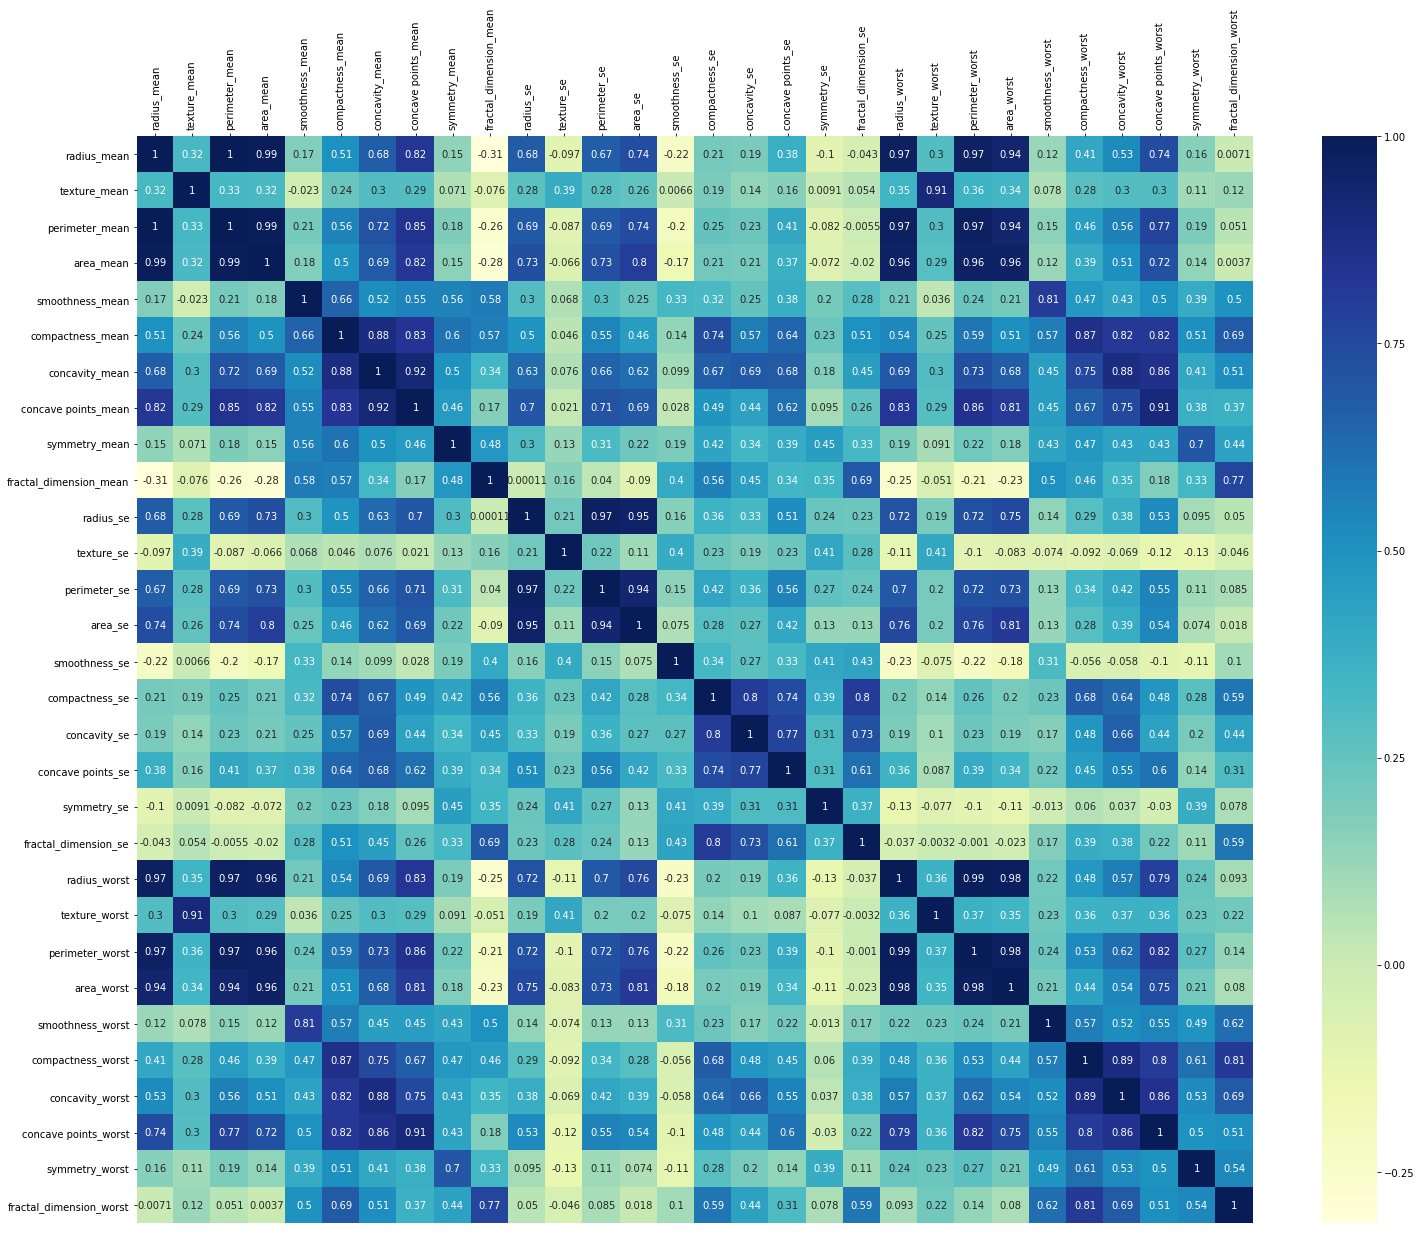

In [15]:
#plot a correlation heatmap
plt.subplots(figsize=(25,20))
hm1 = sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=90)
hm1.xaxis.set_ticks_position('top')

This correlation heatmap helps with feature selection because the gradient shows the correlation between the columns of the dataframe. In order to select only the *significant* predictors, you must eliminate features that are highly correlated with each other (e.g. *correlation* > 0.95).

With respect to predicting the labels, the most significant predictors can be found by plotting boxplots of the numerical values against the labels. The features with boxplots that show the most variance should be chosen as the predictors for your model.

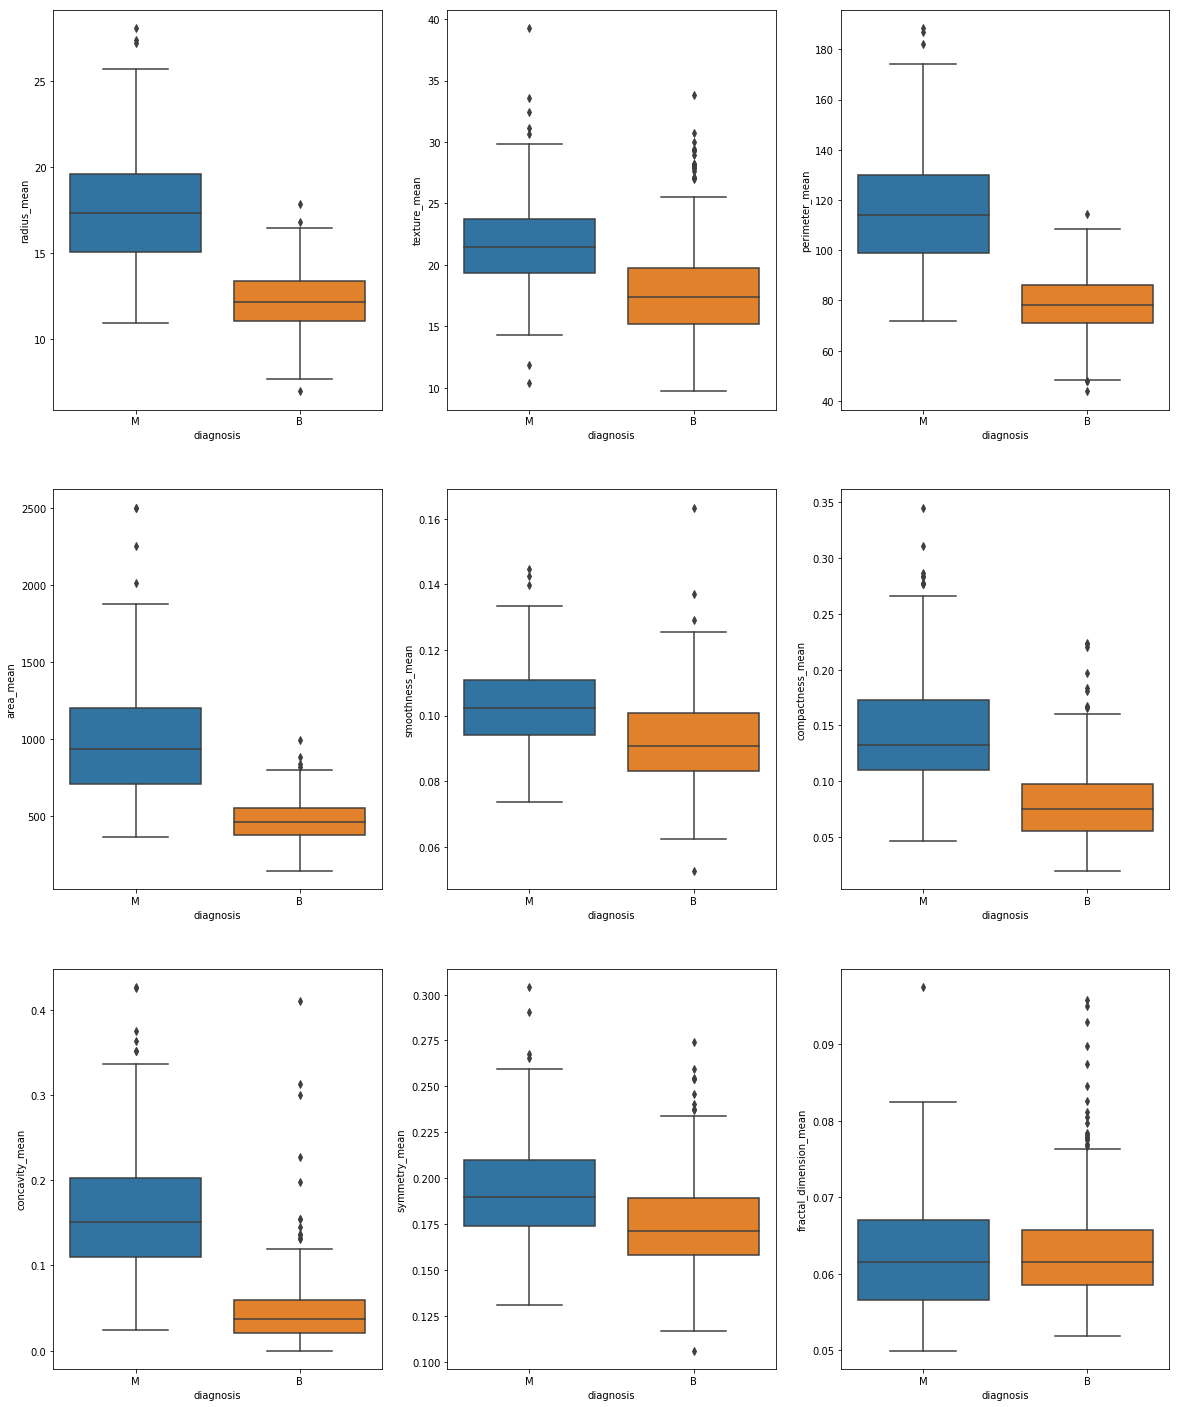

In [16]:
# plot boxplots of numerical columns
cont_list = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list)):
    sns.boxplot(x = 'diagnosis', y = cont_list[i], data=df, ax=ax[i])

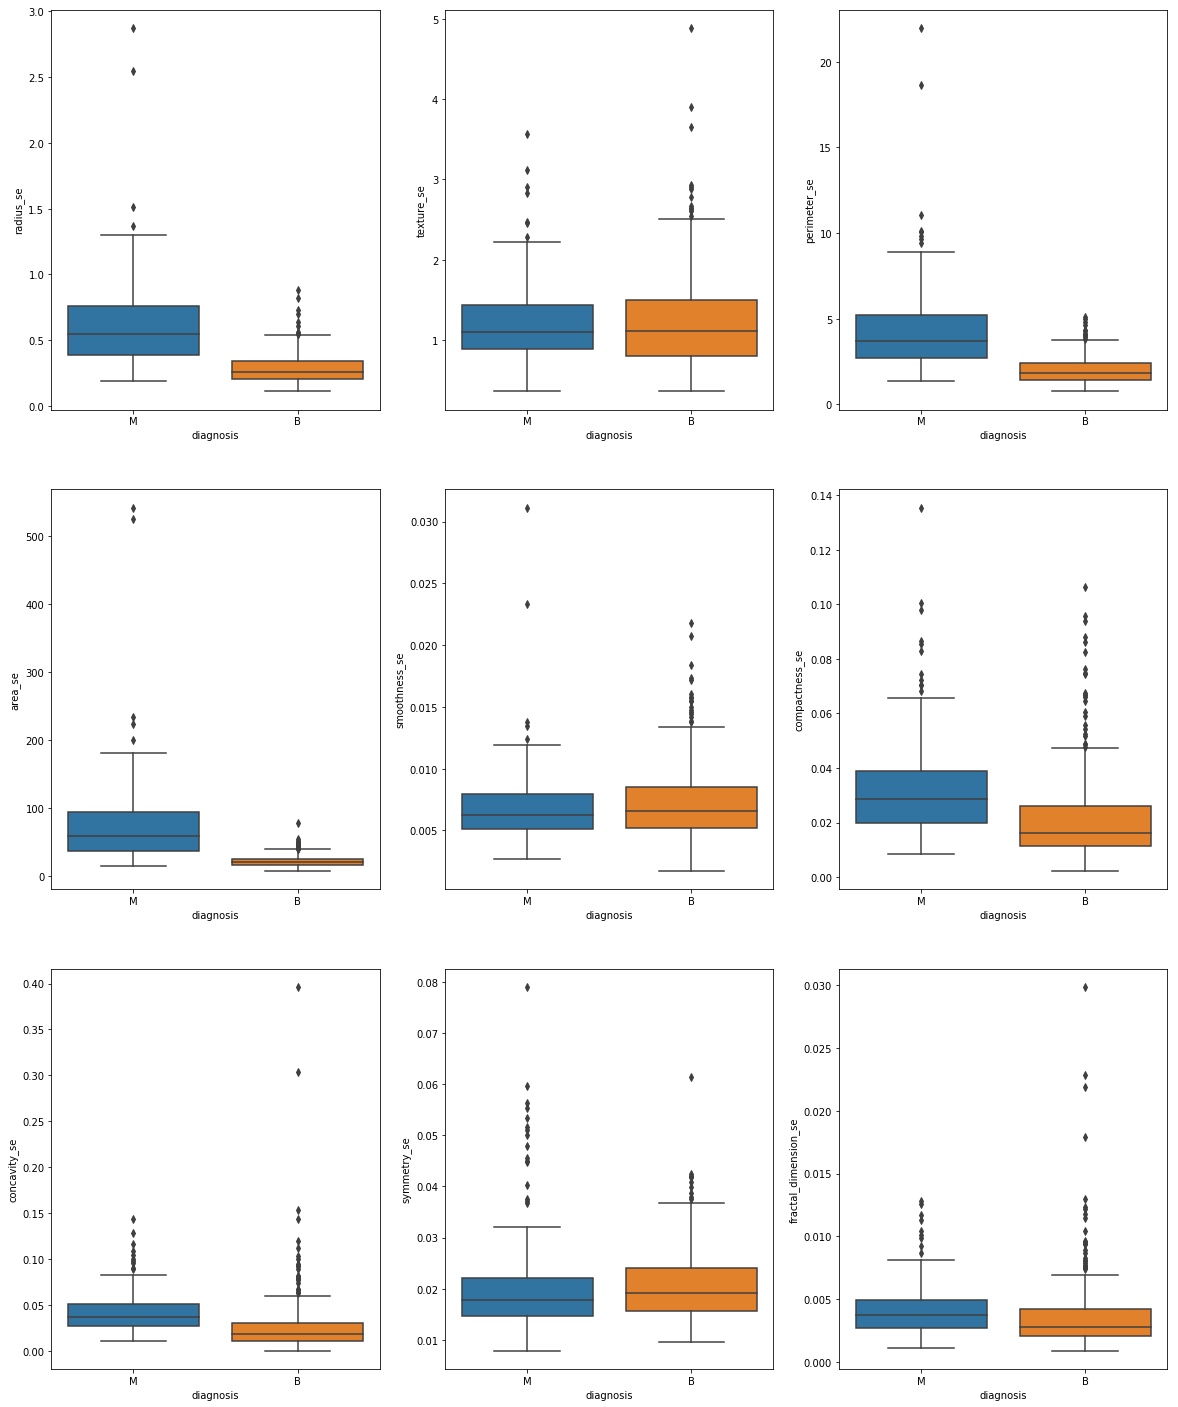

In [17]:
# Plot boxplots of numerical columns.
cont_list2 = ['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list2)):
    sns.boxplot(x = 'diagnosis', y = cont_list2[i], data=df, ax=ax[i])

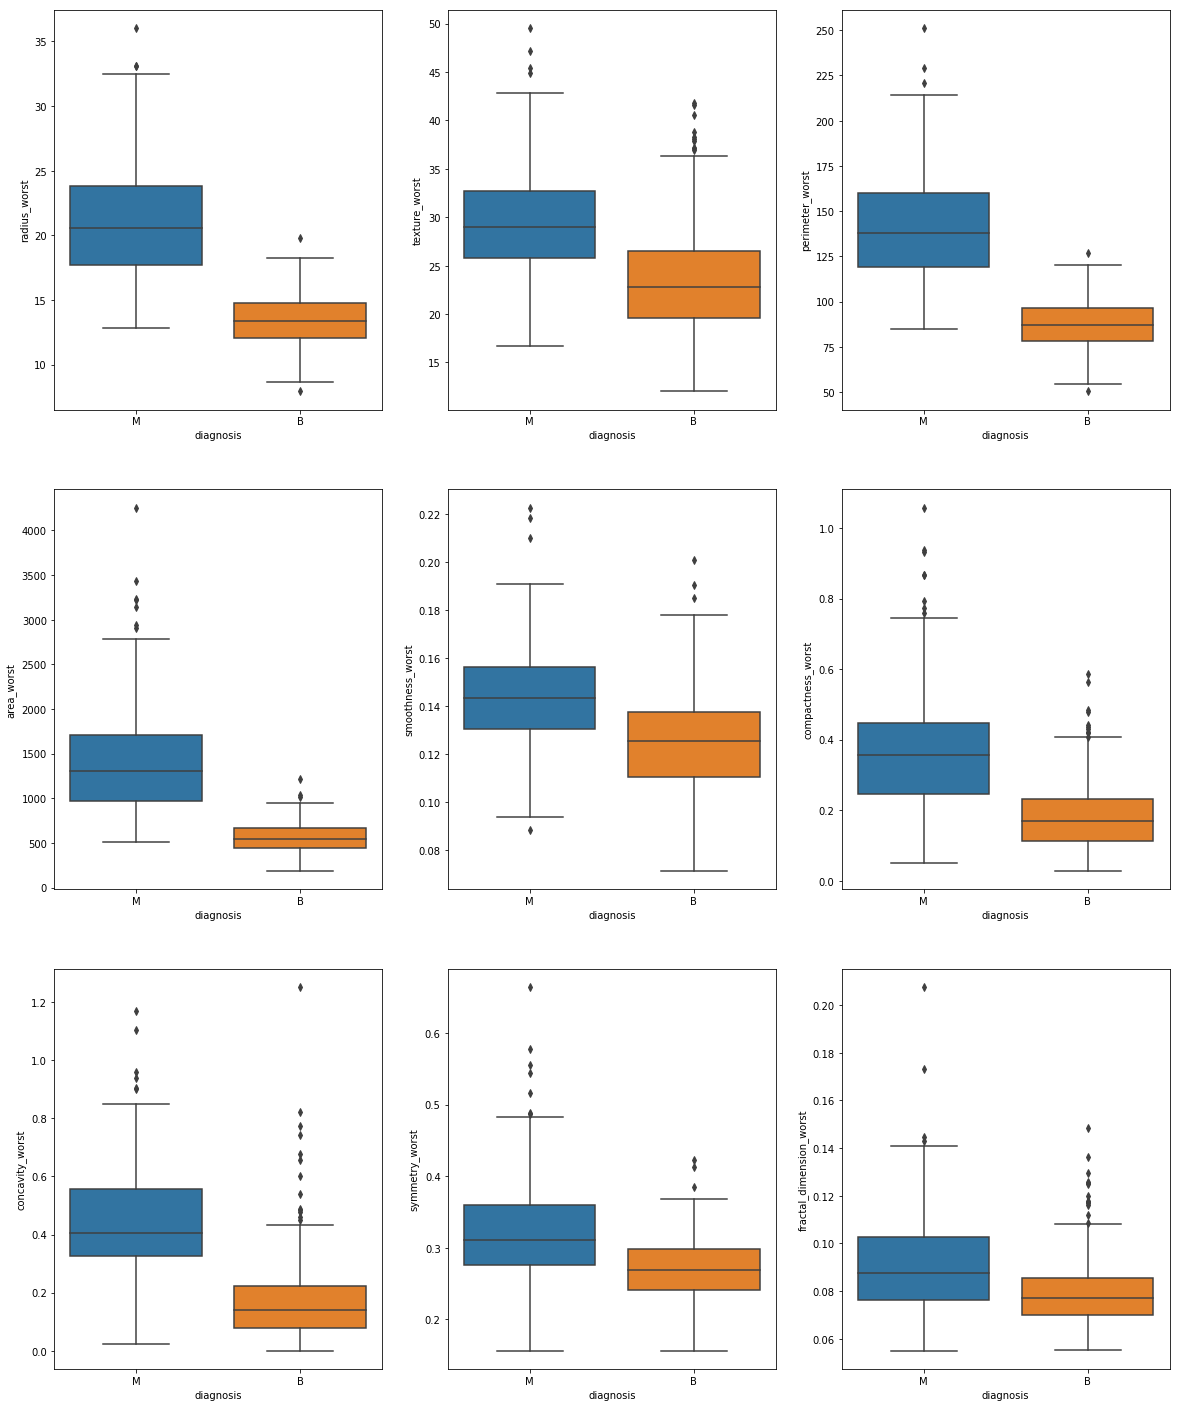

In [18]:
# Plot boxplots of numerical columns.
cont_list3 = ['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list3)):
    sns.boxplot(x = 'diagnosis', y = cont_list3[i], data=df, ax=ax[i])

Here are boxplots of the most significant features:

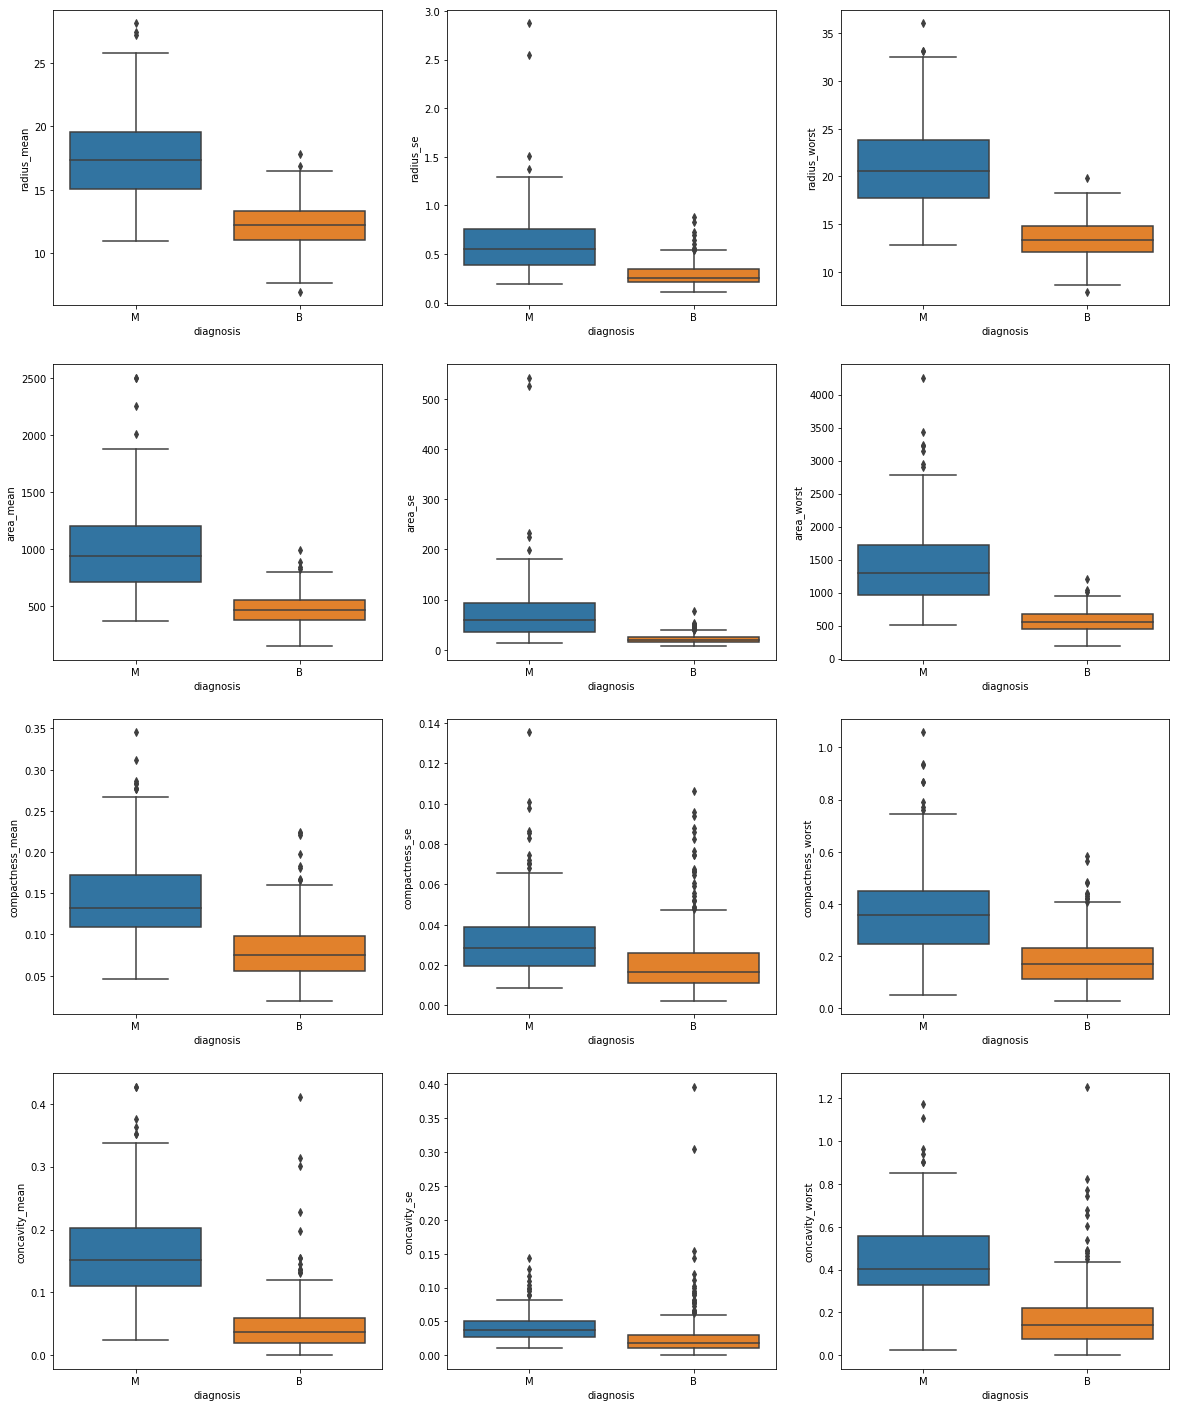

In [19]:
# Compare boxplots of significant numerical columns.
cont_list4 = ['radius_mean', 'radius_se', 'radius_worst', 'area_mean', 'area_se', 'area_worst', 'compactness_mean', 'compactness_se', 'compactness_worst', 'concavity_mean', 'concavity_se', 'concavity_worst']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for i in range(len(cont_list4)):
    sns.boxplot(x = 'diagnosis', y = cont_list4[i], data=df, ax=ax[i])

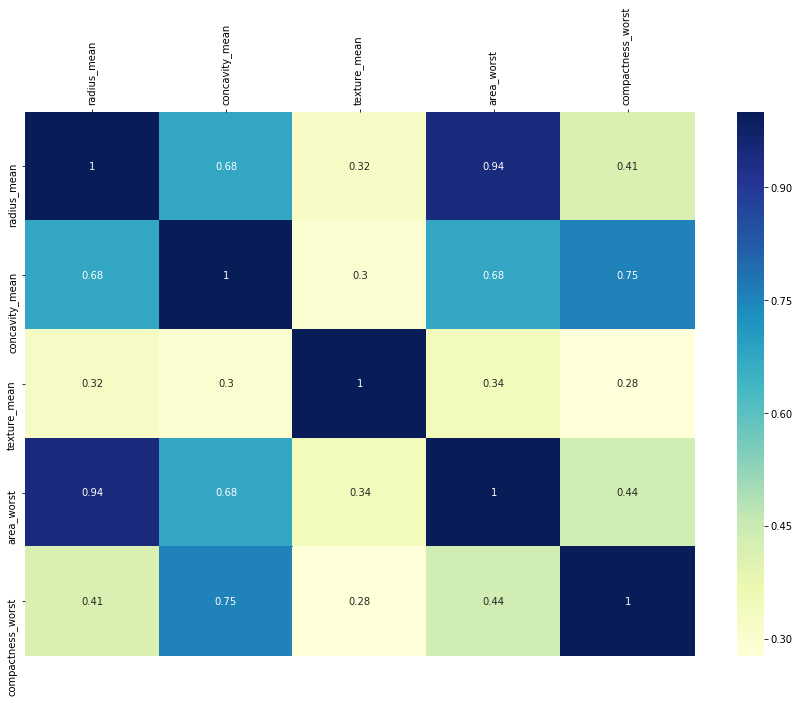

In [20]:
cont_list_f = ['radius_mean', 'concavity_mean', 'texture_mean', 'area_worst', 'compactness_worst']
plt.subplots(figsize=(15,10))
hm2 = sns.heatmap(df[cont_list_f].corr(), annot=True, cmap='YlGnBu')
hm2.set_xticklabels(hm2.get_xticklabels(), rotation=90)
hm2.xaxis.set_ticks_position('top')

By plotting the boxplots of each numerical column against the diagnosis type, we have picked out the significant features/predictors. More variation in the boxplot implies higher significance. We also eliminated features that are highly correlated, therefore, we can choose *radius_mean, radius_se, compactness_worst, concavity_mean, texture_mean* as the predictors for our model.

<a id='model'></a>
## 3. Create an XGBoost model

In this section, you will learn how to train and test an XGBoost model.

- [3.1 Split data](#prepare)
- [3.2 Create an XGBoost model](#create)

### 3.1 Split data<a id='prepare'></a>

In [ ]:
!pip install --upgrade scikit-learn==0.19.1

You will pass the data with the selected significant predictors to build the model. You will use the `diagnosis` column as your target variable.

In [22]:
# Choosing the significant predictors.

X = df.iloc[:, [1,2,7,24,26]]
X = X.values

# Changing the target variables to binary variables
y = (df['diagnosis'] == 'M').astype(int)
y = y.values

Split the data set into: 
- Train data set
- Test data set

In [23]:
# Split the data set and create two data sets.
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=143)

In [24]:
# List the number of records in each data set.
print('Number of training records: ' + str(len(X_train)))
print('Number of testing records : ' + str(len(X_test)))

Number of training records: 369
Number of testing records : 200


The data has been successfully split into two data sets:
- The train data set, which is the largest group, will be used for training.
- The test data set will be used for model evaluation and is used to test the assumptions of the model.

### 3.2 Create an XGBoost model<a id='create'></a>

Install the required packages.<br><br>

<div class="alert-block alert-info"><br>Make sure <tt>xgboost</tt>'s version is 0.80.<br><br>
</div>

In [ ]:
!pip install 'xgboost==0.80'

In [26]:
import xgboost
xgboost.__version__

'0.80'

In [27]:
# Import packages you need to create the XGBoost model.
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#### 3.2.1 Create an XGBoost classifier

In this subsection, you will create an XGBoost classifier with default hyperparameters that you will call *xgb_model*. <br><br>

<div class="alert-block alert-info"><br>The following sections will show you how to improve this base model.<br><br>
</div>

In [28]:
# Create the XGB classifier - xgb_model.
xgb_model = XGBClassifier(n_estimators=100)

Display the default parameters for *xgb_model*.

In [29]:
# List the default parameters.
print(xgb_model.get_xgb_params())

{'base_score': 0.5, 'booster': 'gbtree', 'n_estimators': 100, 'max_depth': 3, 'max_delta_step': 0, 'reg_lambda': 1, 'objective': 'binary:logistic', 'seed': 0, 'subsample': 1, 'colsample_bytree': 1, 'gamma': 0, 'nthread': 1, 'reg_alpha': 0, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'silent': 1, 'min_child_weight': 1, 'colsample_bylevel': 1, 'missing': None}


Now, that your XGBoost classifier *xgb_model* is set up, you can train it by using the fit method. You will also evaluate *xgb_model* as the train and test data are being trained.

In [30]:
# Train and evaluate.
xgb_model.fit(X_train, y_train, eval_metric=['error'], eval_set=[((X_train, y_train)),(X_test, y_test)])

[0]	validation_0-error:0.0271	validation_1-error:0.07
[1]	validation_0-error:0.0271	validation_1-error:0.07
[2]	validation_0-error:0.0271	validation_1-error:0.07
[3]	validation_0-error:0.0271	validation_1-error:0.07
[4]	validation_0-error:0.0271	validation_1-error:0.07
[5]	validation_0-error:0.0271	validation_1-error:0.07
[6]	validation_0-error:0.0271	validation_1-error:0.07
[7]	validation_0-error:0.0271	validation_1-error:0.07
[8]	validation_0-error:0.0271	validation_1-error:0.07
[9]	validation_0-error:0.0271	validation_1-error:0.07
[10]	validation_0-error:0.0271	validation_1-error:0.07
[11]	validation_0-error:0.0271	validation_1-error:0.07
[12]	validation_0-error:0.0271	validation_1-error:0.06
[13]	validation_0-error:0.0271	validation_1-error:0.065
[14]	validation_0-error:0.0271	validation_1-error:0.055
[15]	validation_0-error:0.01897	validation_1-error:0.05
[16]	validation_0-error:0.01897	validation_1-error:0.05
[17]	validation_0-error:0.01897	validation_1-error:0.05
[18]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Plot the model performance that was evaluated during the training process to assess the model overfitting factor.

Text(0.5, 0, 'Number of iterations')

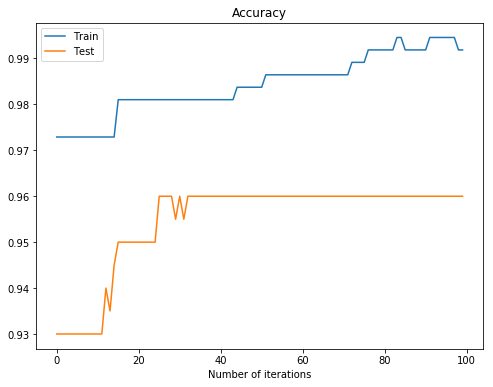

In [31]:
# Plot and display the performance evaluation
xgb_eval = xgb_model.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

You can see that there is model overfitting, and there is no increase in model accuracy after about 40 iterations.

Select the trained model obtained after 40 iterations.

In [32]:
# Select trained model.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
n_trees = 40
y_pred = xgb_model.predict(X_test, ntree_limit= n_trees)

In [33]:
# Check the accuracy of the trained model.
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 96.00%


<div class="alert-block alert-info"><br>You will use the test data accuracy to compare the accuracy of the model with <i>default</i> parameters to the accuracy of the model with <i>tuned</i> parameters.<br><br>
</div>

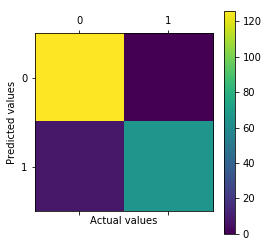

,0,1
0,126,0
1,8,66


In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm)
plt.colorbar()
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()
pd.DataFrame(cm)

This confusion matrix maps the predicted values against the actual values. Here, you can see that 126 benign tumors and 66 malignant tumors have been predicted correctly. However, 8 benign tumors have been incorrectly predicted as malignant. 

Text(0, 0.5, 'True Positive Rate')

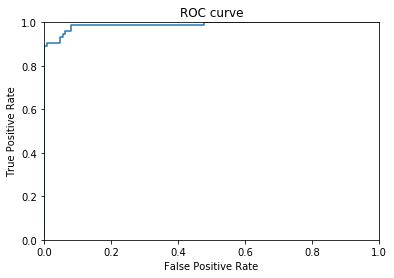

In [35]:
y_pred_prob = xgb_model.predict_proba(X_test)

# ROC-AUC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

This is the ROC-AUC curve - the area under the curve represents the accuracy of the predictions. You can see that the area under the curve is large, indicating that the predictions are highly accurate.

#### 3.2.2 Use grid search and cross-validation to tune the model 

You can use grid search and cross-validation to tune your model to achieve better accuracy.<br><br>

<div class="alert-block alert-info"><br>Grid search is used for this model as an example, but it is <b>not</b> recommended for small data sets such as this one, as it might lead to overfitting.<br><br></div>

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape an algorithm’s desired behavior. Here you will optimize the model tuning which adds an L1 penalty (`reg_alpha`).

Use a 5-fold cross-validation because your training data set is small.

In the cell below, create the XGBoost pipeline and set up the parameter grid for the grid search.

In [36]:
# Create XGBoost pipeline, set up parameter grid.
xgb_model_gs = XGBClassifier()
parameters = {'reg_alpha': [0.0, 1.0, 2.0], 'reg_lambda': [0.0, 1.0, 2.0], 'n_estimators': [n_trees], 'seed': [1337]}

Use ``GridSearchCV`` to search for the best parameters from the specified values in the previous cell.

In [37]:
# Search for the best parameters.
clf = GridSearchCV(estimator = xgb_model_gs, param_grid = parameters, scoring='accuracy', cv=5, verbose=1, n_jobs=1, refit=True, return_train_score=True)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'seed': [1337], 'n_estimators': [40], 'reg_lambda': [0.0, 1.0, 2.0], 'reg_alpha': [0.0, 1.0, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

From the grid scores, you can see performance results of all parameter combinations including the best parameter combination based on model performance.

In [38]:
# View the performance result.
for key in ['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score', 'params', 'rank_test_score']:
    print(key, ": ", clf.cv_results_[key])
#clf.cv_results_

mean_train_score :  [0.9878034  0.98441125 0.98237964 0.98305761 0.98237964 0.98170397
 0.97967236 0.97628711 0.97628711]
std_train_score :  [0.00460484 0.00553239 0.00335588 0.00431358 0.00335588 0.00347903
 0.00217    0.00302744 0.00302744]
mean_test_score :  [0.95392954 0.95392954 0.95663957 0.95934959 0.95934959 0.95663957
 0.95392954 0.95392954 0.95392954]
std_test_score :  [0.02163273 0.02887374 0.02740164 0.02399333 0.02399333 0.02740164
 0.03579064 0.03579064 0.03579064]
params :  [{'seed': 1337, 'n_estimators': 40, 'reg_lambda': 0.0, 'reg_alpha': 0.0}, {'seed': 1337, 'n_estimators': 40, 'reg_lambda': 1.0, 'reg_alpha': 0.0}, {'seed': 1337, 'n_estimators': 40, 'reg_lambda': 2.0, 'reg_alpha': 0.0}, {'seed': 1337, 'n_estimators': 40, 'reg_lambda': 0.0, 'reg_alpha': 1.0}, {'seed': 1337, 'n_estimators': 40, 'reg_lambda': 1.0, 'reg_alpha': 1.0}, {'seed': 1337, 'n_estimators': 40, 'reg_lambda': 2.0, 'reg_alpha': 1.0}, {'seed': 1337, 'n_estimators': 40, 'reg_lambda': 0.0, 'reg_alpha': 

Display the accuracy estimated using cross-validation and the hyperparameter values for the best model.

In [39]:
print('Best score: %.1f%%' % (clf.best_score_*100))
print('Best parameter set: %s' % (clf.best_params_))

Best score: 95.9%
Best parameter set: {'seed': 1337, 'n_estimators': 40, 'reg_lambda': 0.0, 'reg_alpha': 1.0}


Display the accuracy of the best parameter combination on the test set.

In [40]:
y_pred = clf.best_estimator_.predict(X_test, ntree_limit= n_trees)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 95.50%


The test set's accuracy is about the same for both the tuned model and the trained model with default hyperparameter values, even though the tuned hyperparameters are different from the default parameters.

#### 3.2.3 Model with pipeline data preprocessing

In this subsection, you will learn how to use the XGBoost model within the scikit-learn pipeline. 

Let's start by importing the required modules.

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [42]:
pca = PCA(n_components=5)
xgb_model_pca = XGBClassifier(n_estimators=n_trees, reg_lambda=0.0, reg_alpha=1.0)
pipeline = Pipeline(steps=[('pca', pca), ('xgb', xgb_model_pca)])

In [43]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth...    reg_alpha=1.0, reg_lambda=0.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

Now, you are ready to evaluate the accuracy of the model trained on the reduced set of features.

In [44]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 95.50%


You can see that this model has an accuracy similar to the model trained using default hyperparameters.

Let's see how you can save the XGBoost pipeline using the Python client and deploy it for online scoring.

<a id='persistence'></a>
## 4. Persist the model

In this section, you will learn how to use the `watson-machine-learning-client-V4` package to store your XGBoost model in the WML repository.

In [45]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

<div class="alert-block alert-info"><br>The <tt>watson-machine-learning-client</tt> documentation can be found <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">here</a>.<br><br>
</div>

**Authenticate the Python client on Watson Studio Local.**<br><br>

<div class="alert-block alert-info"><br>
To find your authentication information (your credentials) follow the steps provided here in the <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.0.0/wsj/analyze-data/ml-notebook_local.html" target="_blank" rel="noopener no referrer">Documentation</a>.<br><br>
</div>

**Action**: Enter your credentials in the following cell.

In [46]:
wml_credentials={
    'url': '***',
    'username': '***',
    'password': '***',
    'instance_id': 'icp'
}

In [48]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 4.1 Save the XGBoost model in the WML Repository

Save the model artifact as *XGBoost model for breast cancer* to the WML Repository.

You can see the stored predefined runtimes here.

In [49]:
# Predefined runtimes.
client.runtimes.list(pre_defined=True)

--------------------------  --------------------------  ------------------------  --------
GUID                        NAME                        CREATED                   PLATFORM
do_12.9                     do_12.9                     2019-07-27T02:43:25.906Z  do
pmml_4.3                    pmml_4.3                    2019-07-27T02:43:23.635Z  pmml
pmml_4.2.1                  pmml_4.2.1                  2019-07-27T02:43:21.348Z  pmml
pmml_4.2                    pmml_4.2                    2019-07-27T02:43:19.100Z  pmml
pmml_4.1                    pmml_4.1                    2019-07-27T02:43:16.783Z  pmml
pmml_4.0                    pmml_4.0                    2019-07-27T02:43:14.656Z  pmml
pmml_3.2                    pmml_3.2                    2019-07-27T02:43:12.517Z  pmml
pmml_3.1                    pmml_3.1                    2019-07-27T02:43:10.155Z  pmml
pmml_3.0                    pmml_3.0                    2019-07-27T02:43:07.970Z  pmml
ai-function_0.1-py3         ai-functi

Create the model metadata to store in the repository. You can obtain the space UID (one of the MetaNames in the model metadata) by using the following cells.<br><br>

<div class="alert-block alert-info"><br>You can create your own <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.0.0/wsj/analyze-data/ml-spaces_local.html" target="_blank" rel="noopener no referrer">deployment space</a> by selecting <b>Deployment Spaces</b> from the Navigation Menu on the top left of this page.<br><br>
</div>

In [50]:
# Obtain the UId of your space
def guid_from_space_name(client, space_name):
    instance_details = client.service_instance.get_details()
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['guid'])

**Action:** Enter the name of your deployment space in the code below: `space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')`.

In [52]:
# Enter the name of your deployment space here:
space_uid = guid_from_space_name(client, 'YOUR DEPLOYMENT SPACE')
print("Space UID = " + space_uid)

Space UID = 1c428722-4621-4ed3-9f77-7082c338ac35


In [53]:
# Model Metadata.
meta_props={
    client.repository.ModelMetaNames.NAME: "XGBoost model for breast cancer",
    client.repository.ModelMetaNames.RUNTIME_UID: "scikit-learn_0.19-py3",
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.19",
    client.repository.ModelMetaNames.SPACE_UID: space_uid
}

You need the model UID to create the deployment. You can extract the model UID from the saved model details and use it in the next section to create the deployment.

In [54]:
# Create the model artifact.
model_artifact = client.repository.store_model(pipeline,
                                                   meta_props=meta_props,
                                                   training_data=X_train,
                                                   training_target=y_train)
model_uid = client.repository.get_model_uid(model_artifact)
print("Model UID = " + model_uid)

Model UID = 4b496870-fe14-4641-a18f-6538e4feaf07


Get the saved model metadata from WML.

In [55]:
# Details about the model.
model_details = client.repository.get_details(model_uid)
from pprint import pprint
pprint(model_details)

{'entity': {'content_status': {'state': 'persisted'},
            'label_column': 'l1',
            'name': 'XGBoost model for breast cancer',
            'runtime': {'href': '/v4/runtimes/scikit-learn_0.19-py3'},
            'space': {'href': '/v4/spaces/1c428722-4621-4ed3-9f77-7082c338ac35'},
            'training_data_references': [{'connection': {'access_key_id': 'not_applicable',
                                                         'endpoint_url': 'not_applicable',
                                                         'secret_access_key': 'not_applicable'},
                                          'location': {'bucket': 'not_applicable'},
                                          'schema': {'fields': [{'name': 'f0',
                                                                 'type': 'float'},
                                                                {'name': 'f1',
                                                                 'type': 'float'},
                

# 5. Deploy and score in the WML repository <a id="scoring"></a>


In this section, you will learn how to create online scoring and score a new data record in the WML repository.

You can list all stored models using the  `list_models` method.

In [56]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  -------------------------------  ------------------------  -----------------
GUID                                  NAME                             CREATED                   TYPE
4b496870-fe14-4641-a18f-6538e4feaf07  XGBoost model for breast cancer  2019-09-25T23:35:10.069Z  scikit-learn_0.19
------------------------------------  -------------------------------  ------------------------  -----------------


### 5.1 Create a model deployment

Now, you can create a deployment, *Predict breast cancer*.

In [57]:
# Deployment metadata.
deploy_meta = {
    client.deployments.ConfigurationMetaNames.NAME: "Predict breast cancer",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [58]:
# Create the deployment.
deployment_details = client.deployments.create(model_uid, meta_props=deploy_meta)



#######################################################################################

Synchronous deployment creation for uid: '4b496870-fe14-4641-a18f-6538e4feaf07' started

#######################################################################################


initializing


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='381cabc9-1999-4209-bdc8-8e6ecbed0d6d'
------------------------------------------------------------------------------------------------




Get the list of all deployments.

In [59]:
# List the deployments.
client.deployments.list()

------------------------------------  ---------------------  -----  ------------------------  -------------
GUID                                  NAME                   STATE  CREATED                   ARTIFACT_TYPE
381cabc9-1999-4209-bdc8-8e6ecbed0d6d  Predict breast cancer  ready  2019-09-25T23:35:12+0000  model
------------------------------------  ---------------------  -----  ------------------------  -------------


The *Predict breast cancer* model has been successfully deployed.

In [60]:
# Deployment UID.
deployment_uid = client.deployments.get_uid(deployment_details)
print('Deployment uid = {}'.format(deployment_uid))

Deployment uid = 381cabc9-1999-4209-bdc8-8e6ecbed0d6d


### 5.2 Perform prediction

Prepare the scoring payload with the values to score.

In [61]:
# Prepare scoring payload.
job_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [{
        'values': [list(X_test[0]), list(X_test[1])]
    }]
}
pprint(job_payload)

{'scoring_input_data': [{'values': [[12.23, 19.56, 0.04187, 638.4, 0.2042],
                                    [16.27, 20.71, 0.1478, 1121.0, 0.2947]]}]}


In [62]:
# Perform prediction and display the result.
job_details = client.deployments.score(deployment_uid,
                                           job_payload)
pprint(job_details)

{'predictions': [{'fields': ['prediction', 'probability'],
                  'values': [[0, [0.9479249119758606, 0.0520751066505909]],
                             [1, [0.02057337760925293, 0.9794266223907471]]]}]}


**Result**: The patient records are classified as a benign tumor and a malignant tumor respectively.

<a id='summary'></a>
## 6. Summary and next steps     

You have successfully completed this notebook! 

You learned how to use a machine learning algorithm called XGBoost as well as Watson Machine Learning to create and deploy a model. 

### Resources <a id="resources"></a>

To learn more about configurations used in this notebook or more sample notebooks, tutorials, documentation, how-tos, and blog posts, check out these links:

<div class="alert alert-block alert-success">

<h4>IBM documentation</h4>
<br>
 <li> <a href="https://wml-api-pyclient-dev-v4.mybluemix.net" target="_blank" rel="noopener no referrer">watson-machine-learning</a></li> 
 <li> <a href="https://www.ibm.com/support/knowledgecenter/SSHGWL_2.0.0/local/welcome.html" target="_blank" rel="noopener noreferrer">Watson Studio</a></li>
 
<h4> IBM Samples</h4>
<br>
 <li> <a href="https://github.com/IBMDataScience/sample-notebooks" target="_blank" rel="noopener noreferrer">Sample notebooks</a></li>
 
<h4> Others</h4>
<ul>
 <li> <a href="https://www.python.org" target="_blank" rel="noopener noreferrer">Official Python website</a></li>
     <ul>
     <li> <a href="https://pixiedust.github.io/pixiedust/" target="_blank" rel="noopener noreferrer">PixieDust</a></li>
     <li> <a href="https://matplotlib.org" target="_blank" rel="noopener noreferrer">Matplotlib: Python plotting</a></li>
     <li> <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html" target="_blank" rel="noopener noreferrer">scikit-learn: Grid Search</a></li>
     </ul>
 <li> <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html" target="_blank" rel="noopener noreferrer">Pandas DataFrame</a></li>
 <li> <a href="https://seaborn.pydata.org" target="_blank" rel="noopener noreferrer">Seaborn</a></li>
</ul>
 </div>

### Citation

Lichman, M. (2013). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.

### Authors

**Wojciech Sobala** is a Data Scientist at IBM.  
**Ananya Kaushik** is a Data Scientist at IBM.

Copyright © 2017-2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style='background:#F5F7FA; height:110px; padding: 2em; font-size:14px;'>
<span style='font-size:18px;color:#152935;'>Love this notebook? </span>
<span style='font-size:15px;color:#152935;float:right;margin-right:40px;'>Don't have an account yet?</span><br>
<span style='color:#5A6872;'>Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style='border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;'><a href='https://ibm.co/wsnotebooks' target='_blank' style='color: #3d70b2;text-decoration: none;'>Sign Up</a></span><br>
</div>